In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# CSV 파일 불러오기
df = pd.read_csv('Dataset.csv', encoding='utf-8', delimiter='\t')

# 입력 텍스트와 레이블 분리
X = df['content']  # 입력 텍스트
y = df['label']  # 악플 여부(0: 악플, 1: 일반 텍스트)

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# 시퀀스 패딩
max_sequence_length = 100  # 시퀀스 최대 길이 설정
X = pad_sequences(X, maxlen=max_sequence_length)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 훈련 데이터와 검증 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))  # 첫 번째 LSTM 은닉층
model.add(LSTM(64))  # 두 번째 LSTM 은닉층
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=7, batch_size=64, validation_data=(X_val, y_val))

# 모델 평가
print('\n테스트 정확도: %.4f' % (model.evaluate(X_val, y_val)[1]))

Epoch 1/7
125/125 [==============================] - 38s 275ms/step - loss: 0.6440 - accuracy: 0.6076 - val_loss: 0.5470 - val_accuracy: 0.7015
Epoch 2/7
125/125 [==============================] - 31s 251ms/step - loss: 0.1772 - accuracy: 0.9327 - val_loss: 0.6938 - val_accuracy: 0.7165
Epoch 3/7
125/125 [==============================] - 35s 280ms/step - loss: -0.0239 - accuracy: 0.9924 - val_loss: 1.1983 - val_accuracy: 0.7100
Epoch 4/7
125/125 [==============================] - 35s 281ms/step - loss: -0.0594 - accuracy: 0.9965 - val_loss: 1.2428 - val_accuracy: 0.7105
Epoch 5/7
125/125 [==============================] - 34s 269ms/step - loss: -0.0702 - accuracy: 0.9967 - val_loss: 1.7189 - val_accuracy: 0.7125
Epoch 6/7
125/125 [==============================] - 31s 246ms/step - loss: -0.0840 - accuracy: 0.9971 - val_loss: 2.1537 - val_accuracy: 0.7185
Epoch 7/7
63/63 [==============================] - 3s 51ms/step - loss: 2.6417 - accuracy: 0.7170

테스트 정확도: 0.7170


인공신경망을 이용해 지도학습을 시킨 모습이다.
모델은 128, 64개의 유닛을 가진 두 개의 은닉층을 보유하였으며, 출력층 노드는 1개이다.
에포크는 7이 넘어가면서부터 과적합을 보이기 시작해 7까지로 정하였다.
0.6995 정확도를 보였다. 이전에 파악한 데이터 특징들을 가미하여 정확도를 높여보는 시도를 해보겠다.

In [13]:
df = pd.read_csv('Dataset.csv', encoding='utf-8', delimiter='\t')

# 특징 엔지니어링: 댓글의 길이, 단어의 평균 길이, 단어 수 추가
df['comment_length'] = df['content'].apply(lambda x: len(x))
df['average_word_length'] = df['content'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

# 악플과 비악플로 분리
df_malicious = df[df['label'] == 0]
df_non_malicious = df[df['label'] == 1]

from sklearn.feature_extraction.text import CountVectorizer

# 악플 데이터에서 자주 등장하는 단어 추출
vectorizer_malicious = CountVectorizer()
X_malicious = vectorizer_malicious.fit_transform(df_malicious['content'])
malicious_words = vectorizer_malicious.get_feature_names_out()

# 비악플 데이터에서 자주 등장하는 단어 추출
vectorizer_non_malicious = CountVectorizer()
X_non_malicious = vectorizer_non_malicious.fit_transform(df_non_malicious['content'])
non_malicious_words = vectorizer_non_malicious.get_feature_names_out()

# 가장 자주 등장하는 단어들을 합친 후 토크나이저에 추가
# malicious_words와 non_malicious_words의 길이를 맞춤
max_word_count = min(len(malicious_words), len(non_malicious_words))
malicious_words = list(set(malicious_words))[:max_word_count]
non_malicious_words = list(set(non_malicious_words))[:max_word_count]

# 두 리스트 결합
common_words = list(set(malicious_words + non_malicious_words))

# 입력 텍스트와 레이블 분리
X = df['content']  # 입력 텍스트
y = df['label']  # 악플 여부(0: 악플, 1: 일반 텍스트)

# 텍스트 전처리: 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

max_sequence_length = 100  # 시퀀스 최대 길이 설정
X = pad_sequences(X, maxlen=max_sequence_length)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))  # 첫 번째 LSTM 은닉층
model.add(LSTM(64))  # 두 번째 LSTM 은닉층
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=7, batch_size=64, validation_data=(X_test, y_test))
print(history.history)

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('\n테스트 손실: %.4f' % loss)
print('테스트 정확도: %.4f' % accuracy)


Epoch 1/7
125/125 [==============================] - 40s 293ms/step - loss: 0.6424 - accuracy: 0.6051 - val_loss: 0.5393 - val_accuracy: 0.7105
Epoch 2/7
125/125 [==============================] - 33s 268ms/step - loss: 0.1514 - accuracy: 0.9419 - val_loss: 0.6636 - val_accuracy: 0.7270
Epoch 3/7
125/125 [==============================] - 32s 260ms/step - loss: -0.0297 - accuracy: 0.9930 - val_loss: 1.0333 - val_accuracy: 0.7225
Epoch 4/7
125/125 [==============================] - 33s 268ms/step - loss: -0.0615 - accuracy: 0.9962 - val_loss: 1.4202 - val_accuracy: 0.7180
Epoch 5/7
125/125 [==============================] - 37s 299ms/step - loss: -0.0747 - accuracy: 0.9969 - val_loss: 1.5985 - val_accuracy: 0.7125
Epoch 6/7
125/125 [==============================] - 37s 295ms/step - loss: -0.0855 - accuracy: 0.9971 - val_loss: 1.8957 - val_accuracy: 0.7120
Epoch 7/7
125/125 [==============================] - 32s 260ms/step - loss: -0.0950 - accuracy: 0.9971 - val_loss: 2.1045 - val_accu

데이터 특징 중 두 클래스가 다른 모습을 보였던 부분인 댓글의 길이, 단어의 평균 길이, 단어 수를 추가하였고 이후 가장 많이 등장하는 단어들을 추가해 학습시켰다.
다만 불용어, 구두점 삭제 및 특수문자 삭제 부분은 추가하였더니 모델의 성능이 저하되어 삭제했다.

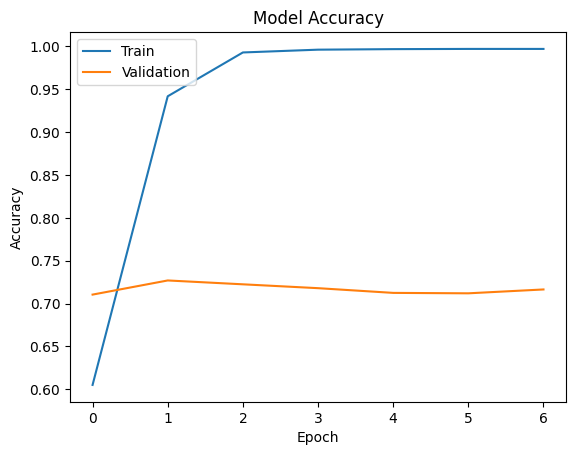

63/63 [==============================] - 5s 55ms/step


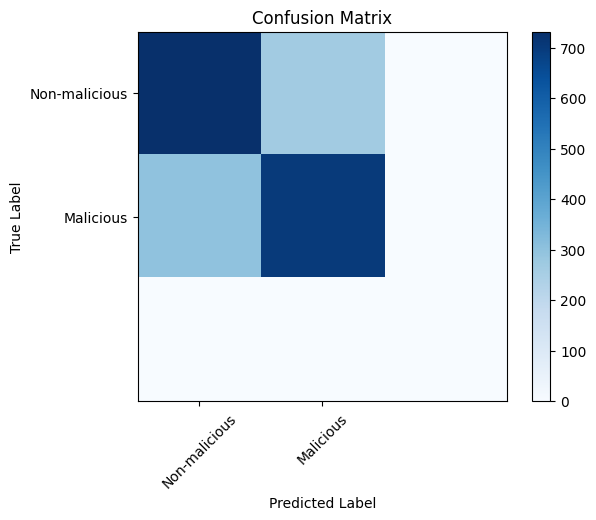

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve

# 학습 곡선 그리기
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 모델 예측
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 그리기
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-malicious', 'Malicious'], rotation=45)
plt.yticks(tick_marks, ['Non-malicious', 'Malicious'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

결과를 그래프로 나타내보았다.
0.7 정확도의 비교적 만족스러운 결과를 얻었지만, 본래 모델의 성능에서 크게 발전되지 않은 모습이다.
아마 이미 모델이 데이터에 관련된 모든 특징을 파악해 학습이 완료된 상태가 아닐까 생각한다.